In [1]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, resize, downscale_local_mean
import math
import os
import numpy as np

import sigpy as sp
import sigpy.plot as pl
import seaborn as sns
sns.set(style='darkgrid', palette='Set2')
from cmcrameri import cm

from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np
import nrrd
import pingouin as pg
import scikit_posthocs as sp

from scipy.signal import argrelextrema

import sys
sys.path.append("/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python")
from mystic_mrpy.Data_Import.Diffusion   import *
from mystic_mrpy.Data_Sorting.Diffusion  import *
from mystic_mrpy.Diffusion.DWI  import *
from mystic_mrpy.Diffusion.Gibbs         import *
from mystic_mrpy.Diffusion.Registration  import *
from mystic_mrpy.Diffusion.Rejection     import *
from mystic_mrpy.Diffusion.Respiratory   import *
from mystic_mrpy.Diffusion.Averaging     import *
from mystic_mrpy.Diffusion.Denoising     import *
from mystic_mrpy.Diffusion.Interpolation import *
from mystic_mrpy.Diffusion.Segmentation_Matrix_DTI import *
from mystic_mrpy.Diffusion.DTI import *
from mystic_mrpy.Diffusion.cDTI import *

import numpy as np
import matplotlib.pyplot as plt

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
# Load in Spatial Gradients

volunteers=[1,2,3,4,5,6,7,8,9,10]
slope_m0 = np.zeros((128,100,3,4,5,10))
slope_m1 = np.zeros((128,100,3,4,5,10))
slope_m2 = np.zeros((128,100,3,4,5,10))

for vv in range(10):

    inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Heart/V00' + str(volunteers[vv]) + '/DWI/'
    
    mask_files_LV = [_ for _ in os.listdir(inpath) if _.startswith('LV')]
    mask_files_BP = [_ for _ in os.listdir(inpath) if _.startswith('BP')]
    
    mask_files_LV.sort()
    mask_files_BP.sort()
    
    
    mm = 0
    for num in range(1,7,2):
        mask_LV,affine, voxsize = load_nifti(os.path.join(inpath, mask_files_LV[mm]), return_voxsize=True)
        mask_BP,affine, voxsize = load_nifti(os.path.join(inpath, mask_files_BP[mm]), return_voxsize=True)
        
        mask_LV_rep = np.tile(mask_LV[:,:,:,np.newaxis,np.newaxis],(1,1,1,4,5))
        mask_BP_rep = np.tile(mask_BP[:,:,:,np.newaxis,np.newaxis],(1,1,1,4,5))
        mask_rep = (mask_LV_rep - mask_BP_rep).astype(np.float32)
        
        mask_rep[mask_rep ==0] = np.nan
        if mask_rep.shape[0] ==100:
            mask_rep = mask_rep.transpose(1,0,2,3,4)
        if num == 1:
            M0_mask = mask_rep
        if num == 3:
            M1_mask = mask_rep
        if num == 5:
            M2_mask = mask_rep


    savename = os.path.join(inpath,'M0_vgrad.npy')
    vgrad = np.load(savename)
    slope_m0[:,:,:,:,:,vv] = np.sqrt(vgrad[0]**2 + vgrad[1]**2) * M0_mask

    savename = os.path.join(inpath,'M1_vgrad.npy')
    vgrad = np.load(savename)
    slope_m1[:,:,:,:,:,vv] = np.sqrt(vgrad[0]**2 + vgrad[1]**2)* M1_mask

    savename = os.path.join(inpath,'M2_vgrad.npy')
    vgrad = np.load(savename)
    slope_m2[:,:,:,:,:,vv] = np.sqrt(vgrad[0]**2 + vgrad[1]**2)* M2_mask
    


In [3]:
M0_std = np.nanstd(slope_m0,axis = -2)#np.sqrt(np.sum((M0_diff)**2,axis = -2)/5)
M1_std = np.nanstd(slope_m1,axis = -2)#np.sqrt(np.sum((M1_diff)**2,axis = -2)/5)
M2_std = np.nanstd(slope_m2,axis = -2)#np.sqrt(np.sum((M2_diff)**2,axis = -2)/5)

M0_avg = np.nanmean(slope_m0,axis = -2)#np.sqrt(np.sum((M0_diff)**2,axis = -2)/5)
M1_avg = np.nanmean(slope_m1,axis = -2)#np.sqrt(np.sum((M1_diff)**2,axis = -2)/5)
M2_avg = np.nanmean(slope_m2,axis = -2)#np.sqrt(np.sum((M2_diff)**2,axis = -2)/5)


M0_std_mean = np.nanmean(M0_std, axis = (0,1))
M1_std_mean = np.nanmean(M1_std, axis = (0,1))
M2_std_mean = np.nanmean(M2_std, axis = (0,1))

std_all = np.stack((M0_std_mean,M1_std_mean,M2_std_mean),axis = -1)

M0_avg_mean = np.nanmean(M0_avg, axis = (0,1))
M1_avg_mean = np.nanmean(M1_avg, axis = (0,1))
M2_avg_mean = np.nanmean(M2_avg, axis = (0,1))

avg_all = np.stack((M0_avg_mean,M1_avg_mean,M2_avg_mean),axis = -1)



/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-3-28438a660e43>:5: RuntimeWarning: Mean of empty slice
  M0_avg = np.nanmean(slope_m0,axis = -2)#np.sqrt(np.sum((M0_diff)**2,axis = -2)/5)
<ipython-input-3-28438a660e43>:6: RuntimeWarning: Mean of empty slice
  M1_avg = np.nanmean(slope_m1,axis = -2)#np.sqrt(np.sum((M1_diff)**2,axis = -2)/5)
<ipython-input-3-28438a660e43>:7: RuntimeWarning: Mean of empty slice
  M2_avg = np.nanmean(slope_m2,axis = -2)#np.sqrt(np.sum((M2_diff)**2,axis = -2)/5)


In [4]:
import pandas as pd
std_all.shape

(3, 4, 10, 3)

In [5]:
data.shape

NameError: name 'data' is not defined

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<Axes: >

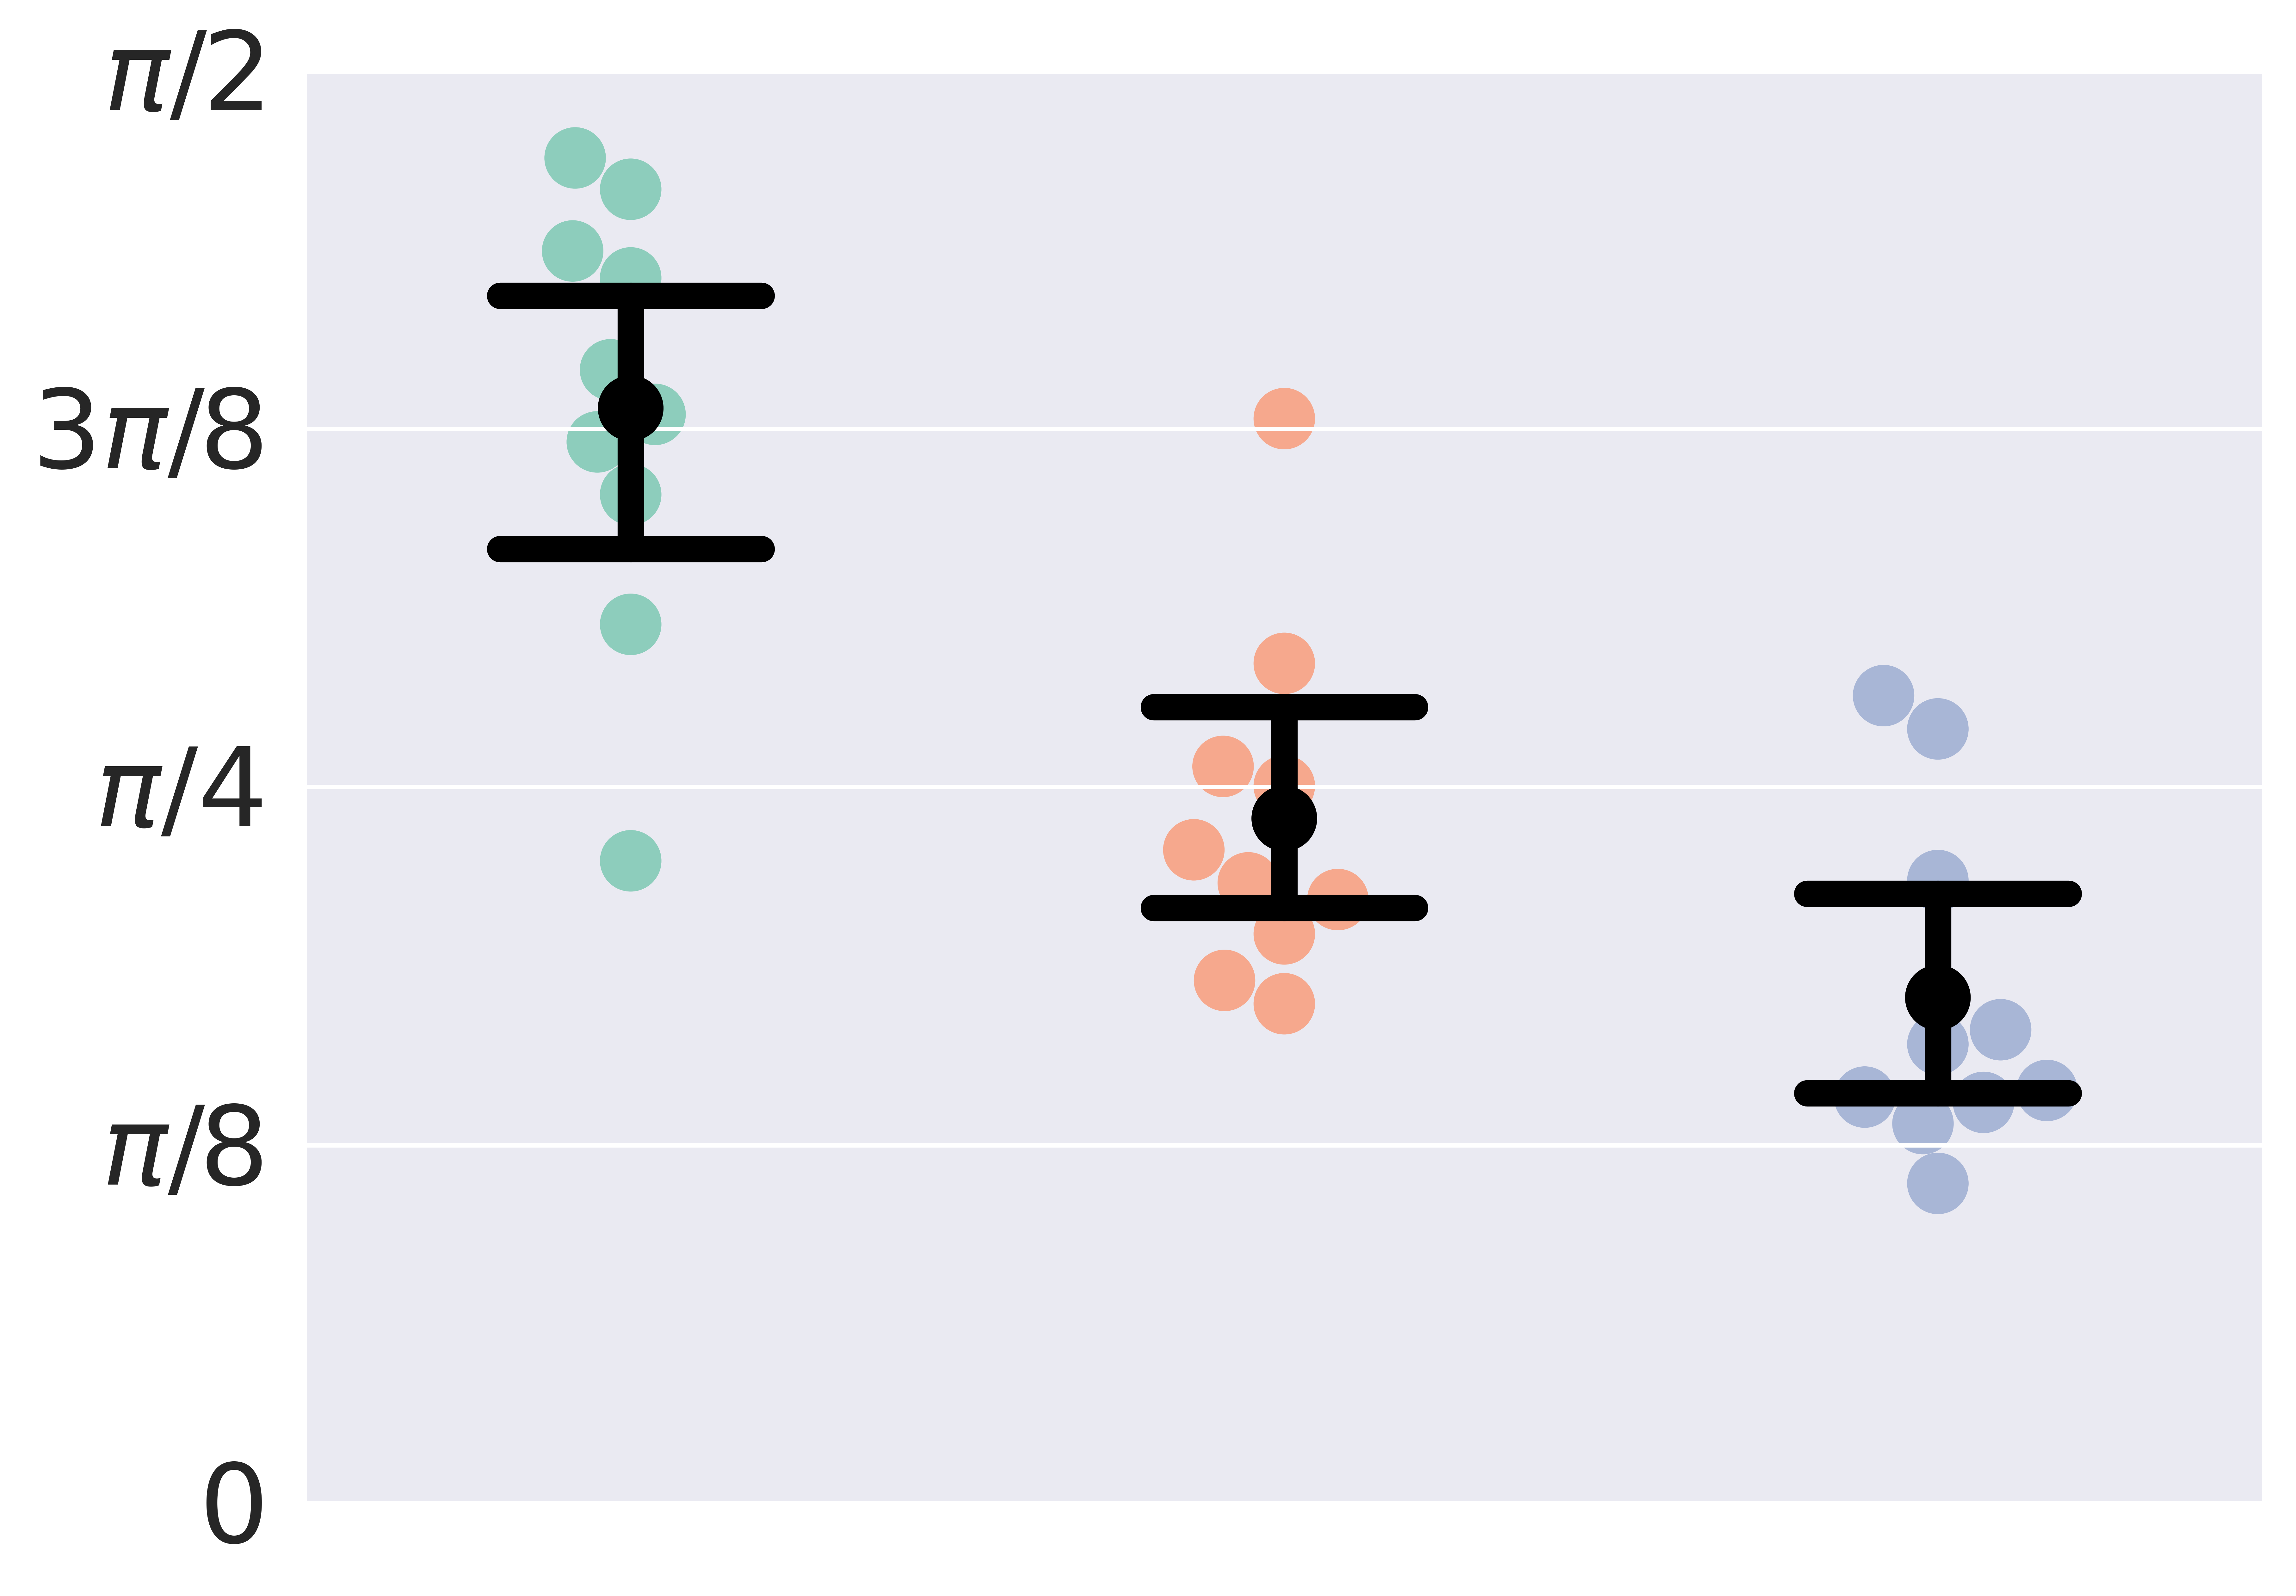

In [6]:

dd = 1
sl = 1

data = pd.DataFrame(avg_all[sl,dd,:,:])

fig, axes = plt.subplots(1, 1, figsize=(8,6),sharex=True,sharey = True,dpi=1000)
count = 0
slices = [0,1,2]



axes.set_xticks([0,1,2])
axes.set_xticklabels(['1','2','3'],size = 1,color='white')
axes.tick_params(axis='y', which='major', labelsize=35)
axes.tick_params(axis='x', which='major', labelsize=35)
axes.set_yticks([0,math.pi/8,math.pi/4,3*math.pi/8,math.pi/2])
axes.set_yticklabels(['$0$','$\pi/8$','$\pi/4$','$3\pi/8$','$\pi/2$'],size = 25,rotation = 0)
axes.set_ylim([0,math.pi/2])
axes.set_xlim([-0.2,2.2])
axes.set_xticks([0,1,2])
axes.set_xticklabels([0,1,2],size = 1,color = 'white',rotation = 0)
        
sns.swarmplot(data=data,color = 'black',
    size = 14,zorder = 0,edgecolor='gray', ax = axes,palette='Set2',alpha = 0.7)


sns.pointplot(
    data=data,color = 'black',errwidth=6,scale = 1.7,
    errorbar=("se",data), capsize=.4, join=False, orient ='v',ax=axes,
)






In [7]:

dd = 1
sl = 2



fig, axes = plt.subplots(3, 4, figsize=(15,15),sharex=True,sharey = True,dpi=1000)
count = 0
slices = [2,1,0]


for dd in range(4):
    for sl in range(3):
        data = pd.DataFrame(std_all[slices[sl],dd,:,:])
        axes[sl,dd].set_xticks([0,1,2])
        axes[sl,dd].set_xticklabels(['1','2','3'],size = 1,color='white')
        axes[sl,dd].tick_params(axis='y', which='major', labelsize=35)
        axes[sl,dd].tick_params(axis='x', which='major', labelsize=35)
        axes[sl,dd].set_yticks([0,math.pi/16,math.pi/8,3*math.pi/16,math.pi/4])
        axes[sl,dd].set_yticklabels(['$0$','$\pi/16$','$\pi/8$','$3\pi/16$','$\pi/4$'],size = 25,rotation = 0)
        axes[sl,dd].set_ylim([0,math.pi/4])
        axes[sl,dd].set_xlim([-0.2,2.2])
        axes[sl,dd].set_xticks([0,1,2])
        axes[sl,dd].set_xticklabels([0,1,2],size = 1,color = 'white',rotation = 0)
                
        sns.swarmplot(data=data,color = 'black',
            size = 12,zorder = 0,edgecolor='gray', ax = axes[sl,dd],palette='Set2',alpha = 0.7)


        sns.pointplot(
            data=data,color = 'black',errwidth=6,scale = 1.7,
            errorbar=("se",data), capsize=.4, join=False, orient ='v',ax=axes[sl,dd],
        )

plt.subplots_adjust(wspace=0.05, hspace=0.1)  
plt.show()





/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/arielhannu

In [10]:

dd = 1
sl = 2



fig, axes = plt.subplots(3, 4, figsize=(15,10),sharex=True,sharey = True,dpi=1000)
count = 0
slices = [2,1,0]


for dd in range(4):
    for sl in range(3):
        data = pd.DataFrame(avg_all[slices[sl],dd,:,:])
        axes[sl,dd].set_xticks([0,1,2])
        axes[sl,dd].set_xticklabels(['1','2','3'],size = 1,color='white')
        axes[sl,dd].tick_params(axis='y', which='major', labelsize=35)
        axes[sl,dd].tick_params(axis='x', which='major', labelsize=35)
        axes[sl,dd].set_yticks([0,math.pi/8,math.pi/4,3*math.pi/8,math.pi/2])
        axes[sl,dd].set_yticklabels(['$0$','$\pi/8$','$\pi/4$','$3\pi/8$','$\pi/2$'],size = 25,rotation = 0)
        axes[sl,dd].set_ylim([0,math.pi/2])
        axes[sl,dd].set_xlim([-0.2,2.2])
        axes[sl,dd].set_xticks([0,1,2])
        axes[sl,dd].set_xticklabels([0,1,2],size = 1,color = 'white',rotation = 0)
                
        sns.swarmplot(data=data,color = 'black',
            size = 12,zorder = 0,edgecolor='gray', ax = axes[sl,dd],palette='Set2',alpha = 0.7)


        sns.pointplot(
            data=data,color = 'black',errwidth=6,scale = 1.7,
            errorbar=("se",data), capsize=.4, join=False, orient ='v',ax=axes[sl,dd],
        )

plt.subplots_adjust(wspace=0.05, hspace=0.15)  
plt.show()





/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt

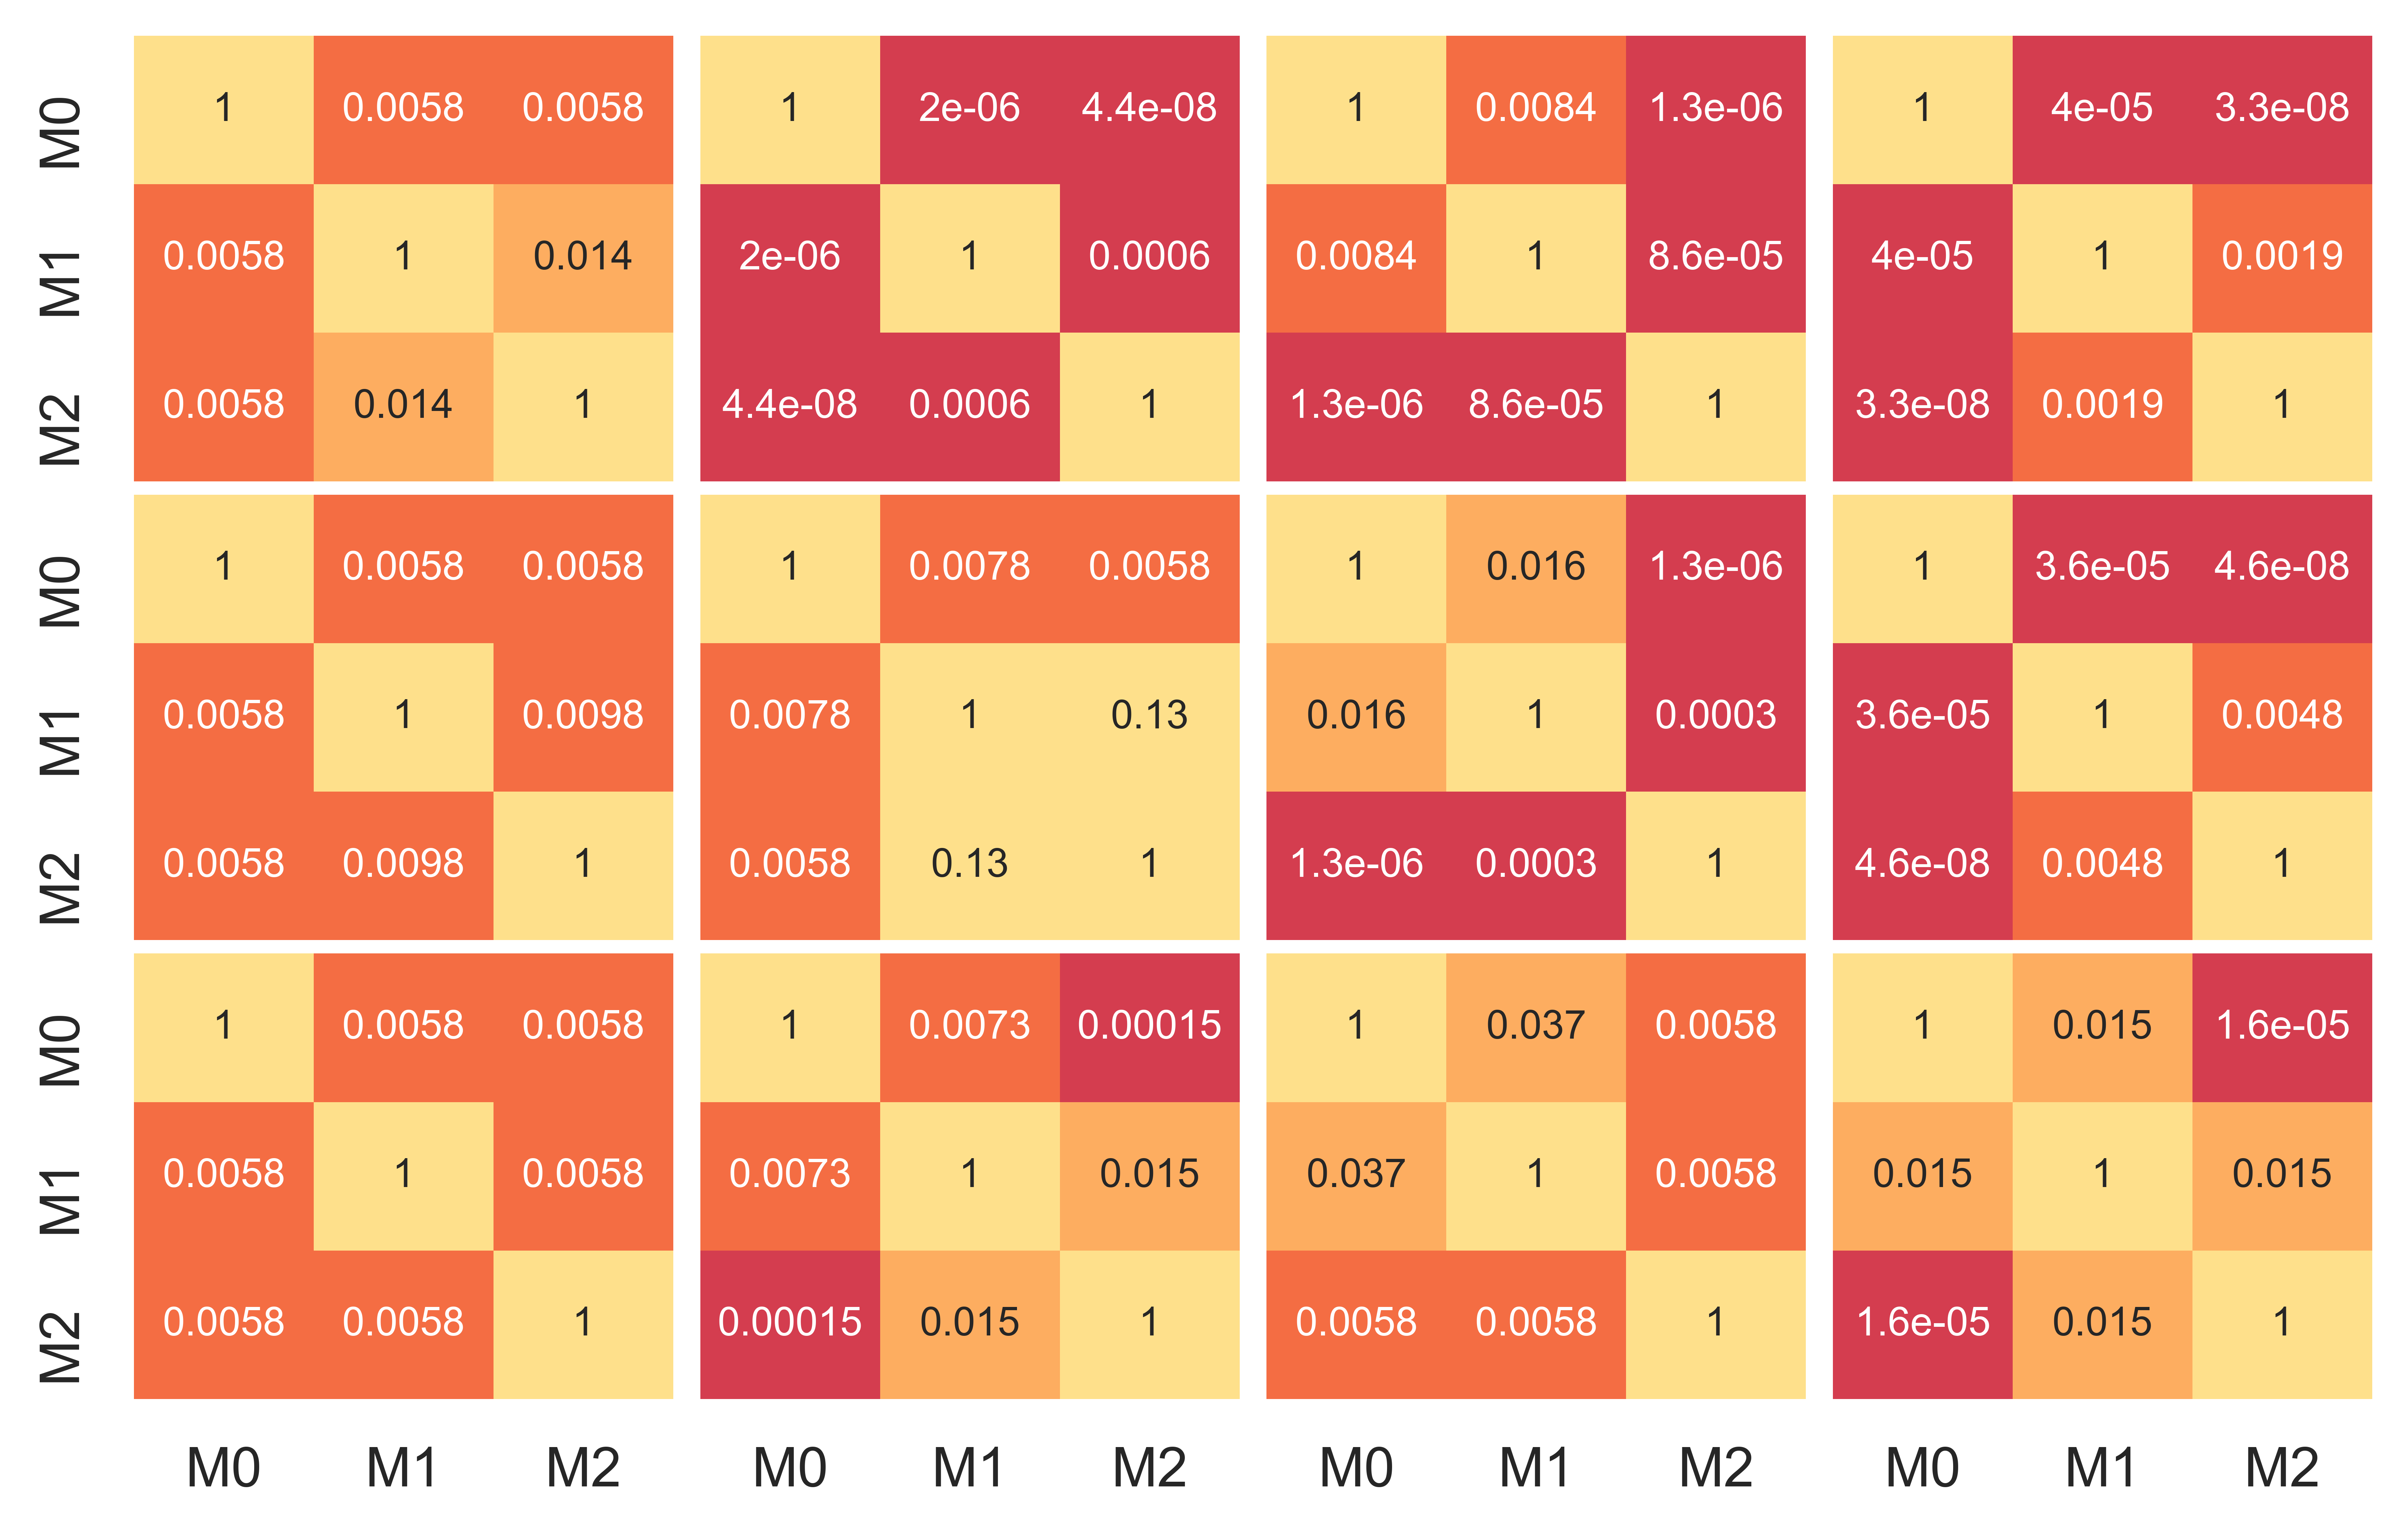

In [21]:
# Looking at Confidence intervals of the phase differences seeing if there is significant decrease with increasing motion compensation
import scikit_posthocs as sp
from scipy import stats
alpha= 0.05

hypothesis = np.zeros((3,4,3,3))
hypothesis[:] = np.nan

slices = [2,1,0]
for sl in range(3):
    for dd in range(4):
        group1 = avg_all[slices[sl],dd,:,0]
        group2 = avg_all[slices[sl],dd,:,1]
        group3 = avg_all[slices[sl],dd,:,2]

        tests = [stats.shapiro(group1)[1] <alpha,stats.shapiro(group2)[1] <alpha, stats.shapiro(group3)[1] <alpha]
        if np.sum(tests) > 0:
            normal = 0
        else:
            normal = 1

        if normal ==0:
            result = stats.friedmanchisquare(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_wilcoxon([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test
            else:
                hypothesis[sl,dd,:,:] = np.nan

        elif normal ==1:
            result = stats.f_oneway(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_ttest([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test 
            else:
                hypothesis[sl,dd,:,:] = np.nan



from matplotlib.colors import BoundaryNorm, ListedColormap
import seaborn as sns
import numpy as np

my_colors = [sns.color_palette("Spectral",9)[0], sns.color_palette("Spectral",9)[1], sns.color_palette("Spectral",9)[2], 
            sns.color_palette("Spectral",9)[3]]
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.001, 0.01, 0.05,1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

fig, axes = plt.subplots(3, 4, figsize=(8,5),sharex=True,sharey = True,dpi=1000)
count = 2
for sl in range(3):
    for dirs in range(4):
        ax=sns.heatmap(hypothesis[count,dirs,:,:],ax = axes[sl,dirs], annot = True, xticklabels=['M0','M1','M2'],
                    yticklabels=['M0','M1','M2'],norm=my_norm,cmap = my_cmap,cbar = False,annot_kws={"fontsize":8})
        #c_bar = ax.collections[0].colorbar
        #c_bar.set_ticks([(0 + 0.001)/2,(0.001+0.01)/2,(0.01+0.05)/2,(0.05+1)/2])
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  


    count = count -1

plt.subplots_adjust(wspace=0.05, hspace=0.03)




In [22]:
print('test slices signifiance')
std_all.shape

test slices signifiance


(3, 4, 10, 3)

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


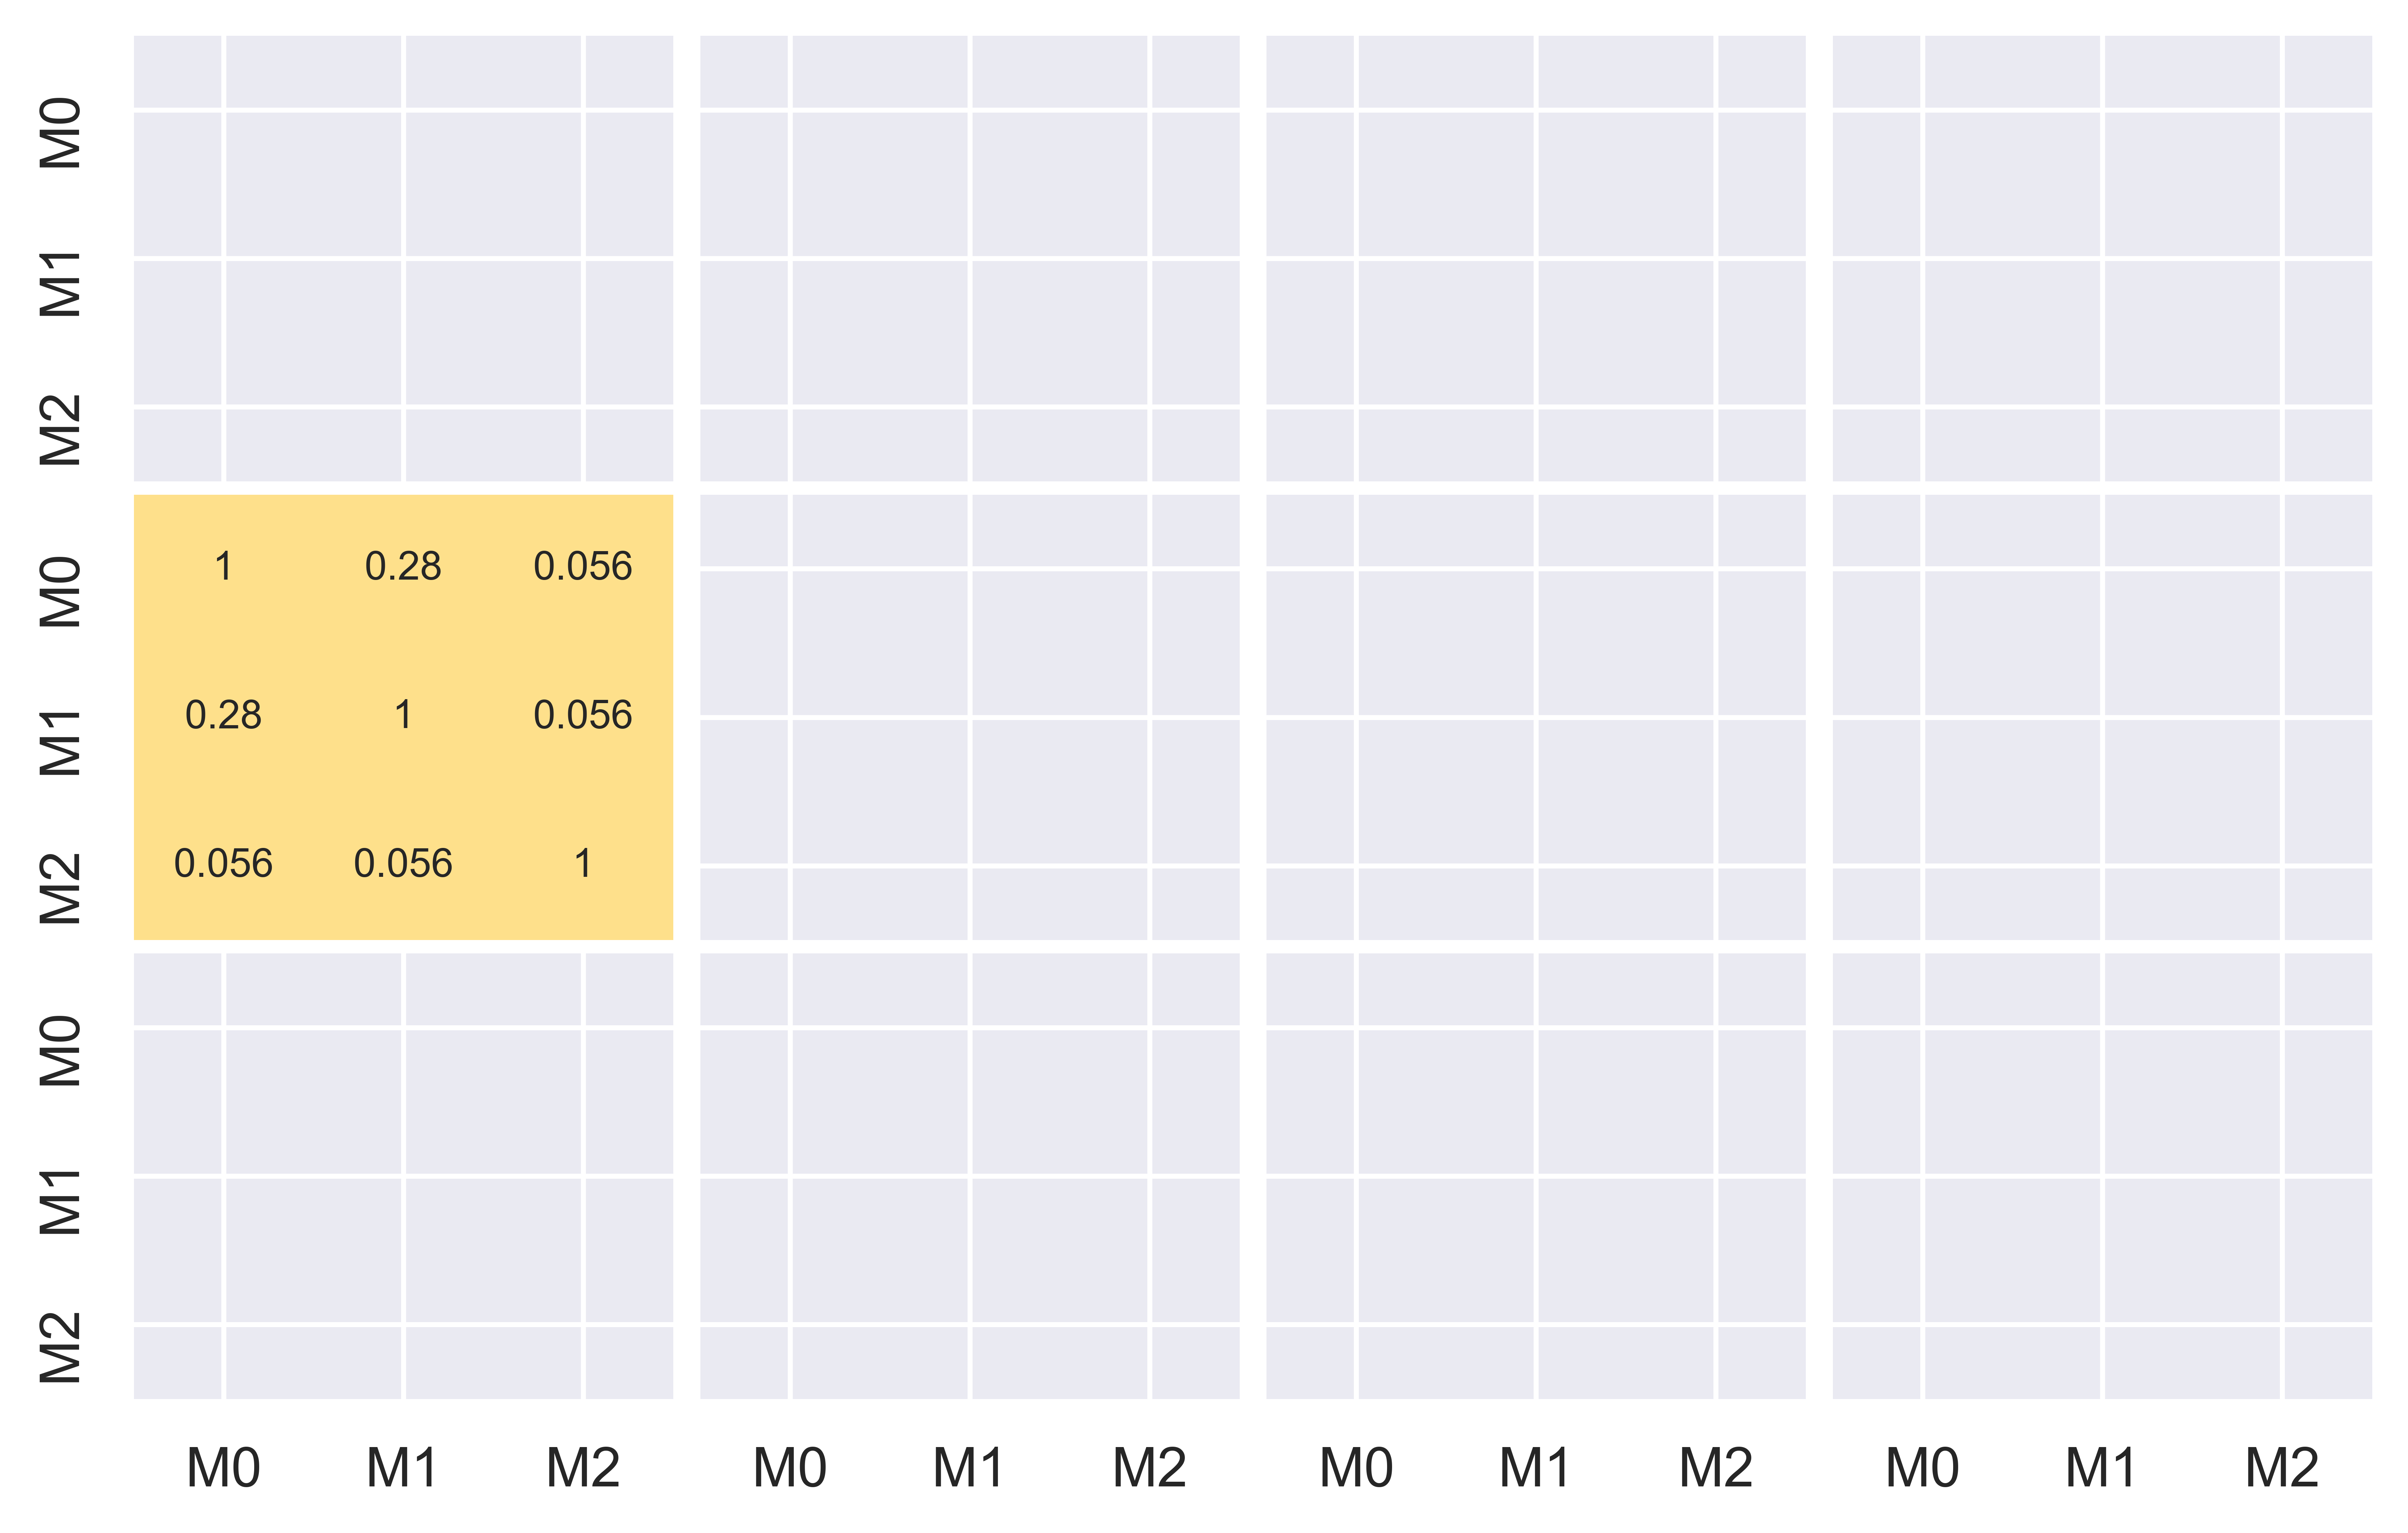

In [23]:
# Looking at signifiance between slices 
import scikit_posthocs as sp
from scipy import stats
alpha= 0.05

hypothesis = np.zeros((3,4,3,3))
hypothesis[:] = np.nan

slices = [2,1,0]
for sl in range(3):
    for dd in range(4):
        group1 = std_all[0,dd,:,sl]
        group2 = std_all[1,dd,:,sl]
        group3 = std_all[2,dd,:, sl]

        normal = 0 if stats.shapiro(group1)[1] <alpha or stats.shapiro(group2)[1] <alpha or stats.shapiro(group1)[1] <alpha else 1

        if normal ==0:
            result = stats.friedmanchisquare(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_wilcoxon([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test
            else:
                hypothesis[sl,dd,:,:] = np.nan

        elif normal ==1:
            result = stats.f_oneway(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_ttest([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test 
            else:
                hypothesis[sl,dd,:,:] = np.nan



from matplotlib.colors import BoundaryNorm, ListedColormap
import seaborn as sns
import numpy as np

my_colors = [sns.color_palette("Spectral",9)[0], sns.color_palette("Spectral",9)[1], sns.color_palette("Spectral",9)[2], 
            sns.color_palette("Spectral",9)[3]]
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.001, 0.01, 0.05,1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

fig, axes = plt.subplots(3, 4, figsize=(8,5),sharex=True,sharey = True,dpi=1000)
count = 2
for sl in range(3):
    for dirs in range(4):
        ax=sns.heatmap(hypothesis[count,dirs,:,:],ax = axes[sl,dirs], annot = True, xticklabels=['M0','M1','M2'],
                    yticklabels=['M0','M1','M2'],norm=my_norm,cmap = my_cmap,cbar = False,annot_kws={"fontsize":8})
        #c_bar = ax.collections[0].colorbar
        #c_bar.set_ticks([(0 + 0.001)/2,(0.001+0.01)/2,(0.01+0.05)/2,(0.05+1)/2])
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  


    count = count -1

plt.subplots_adjust(wspace=0.05, hspace=0.03)




/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


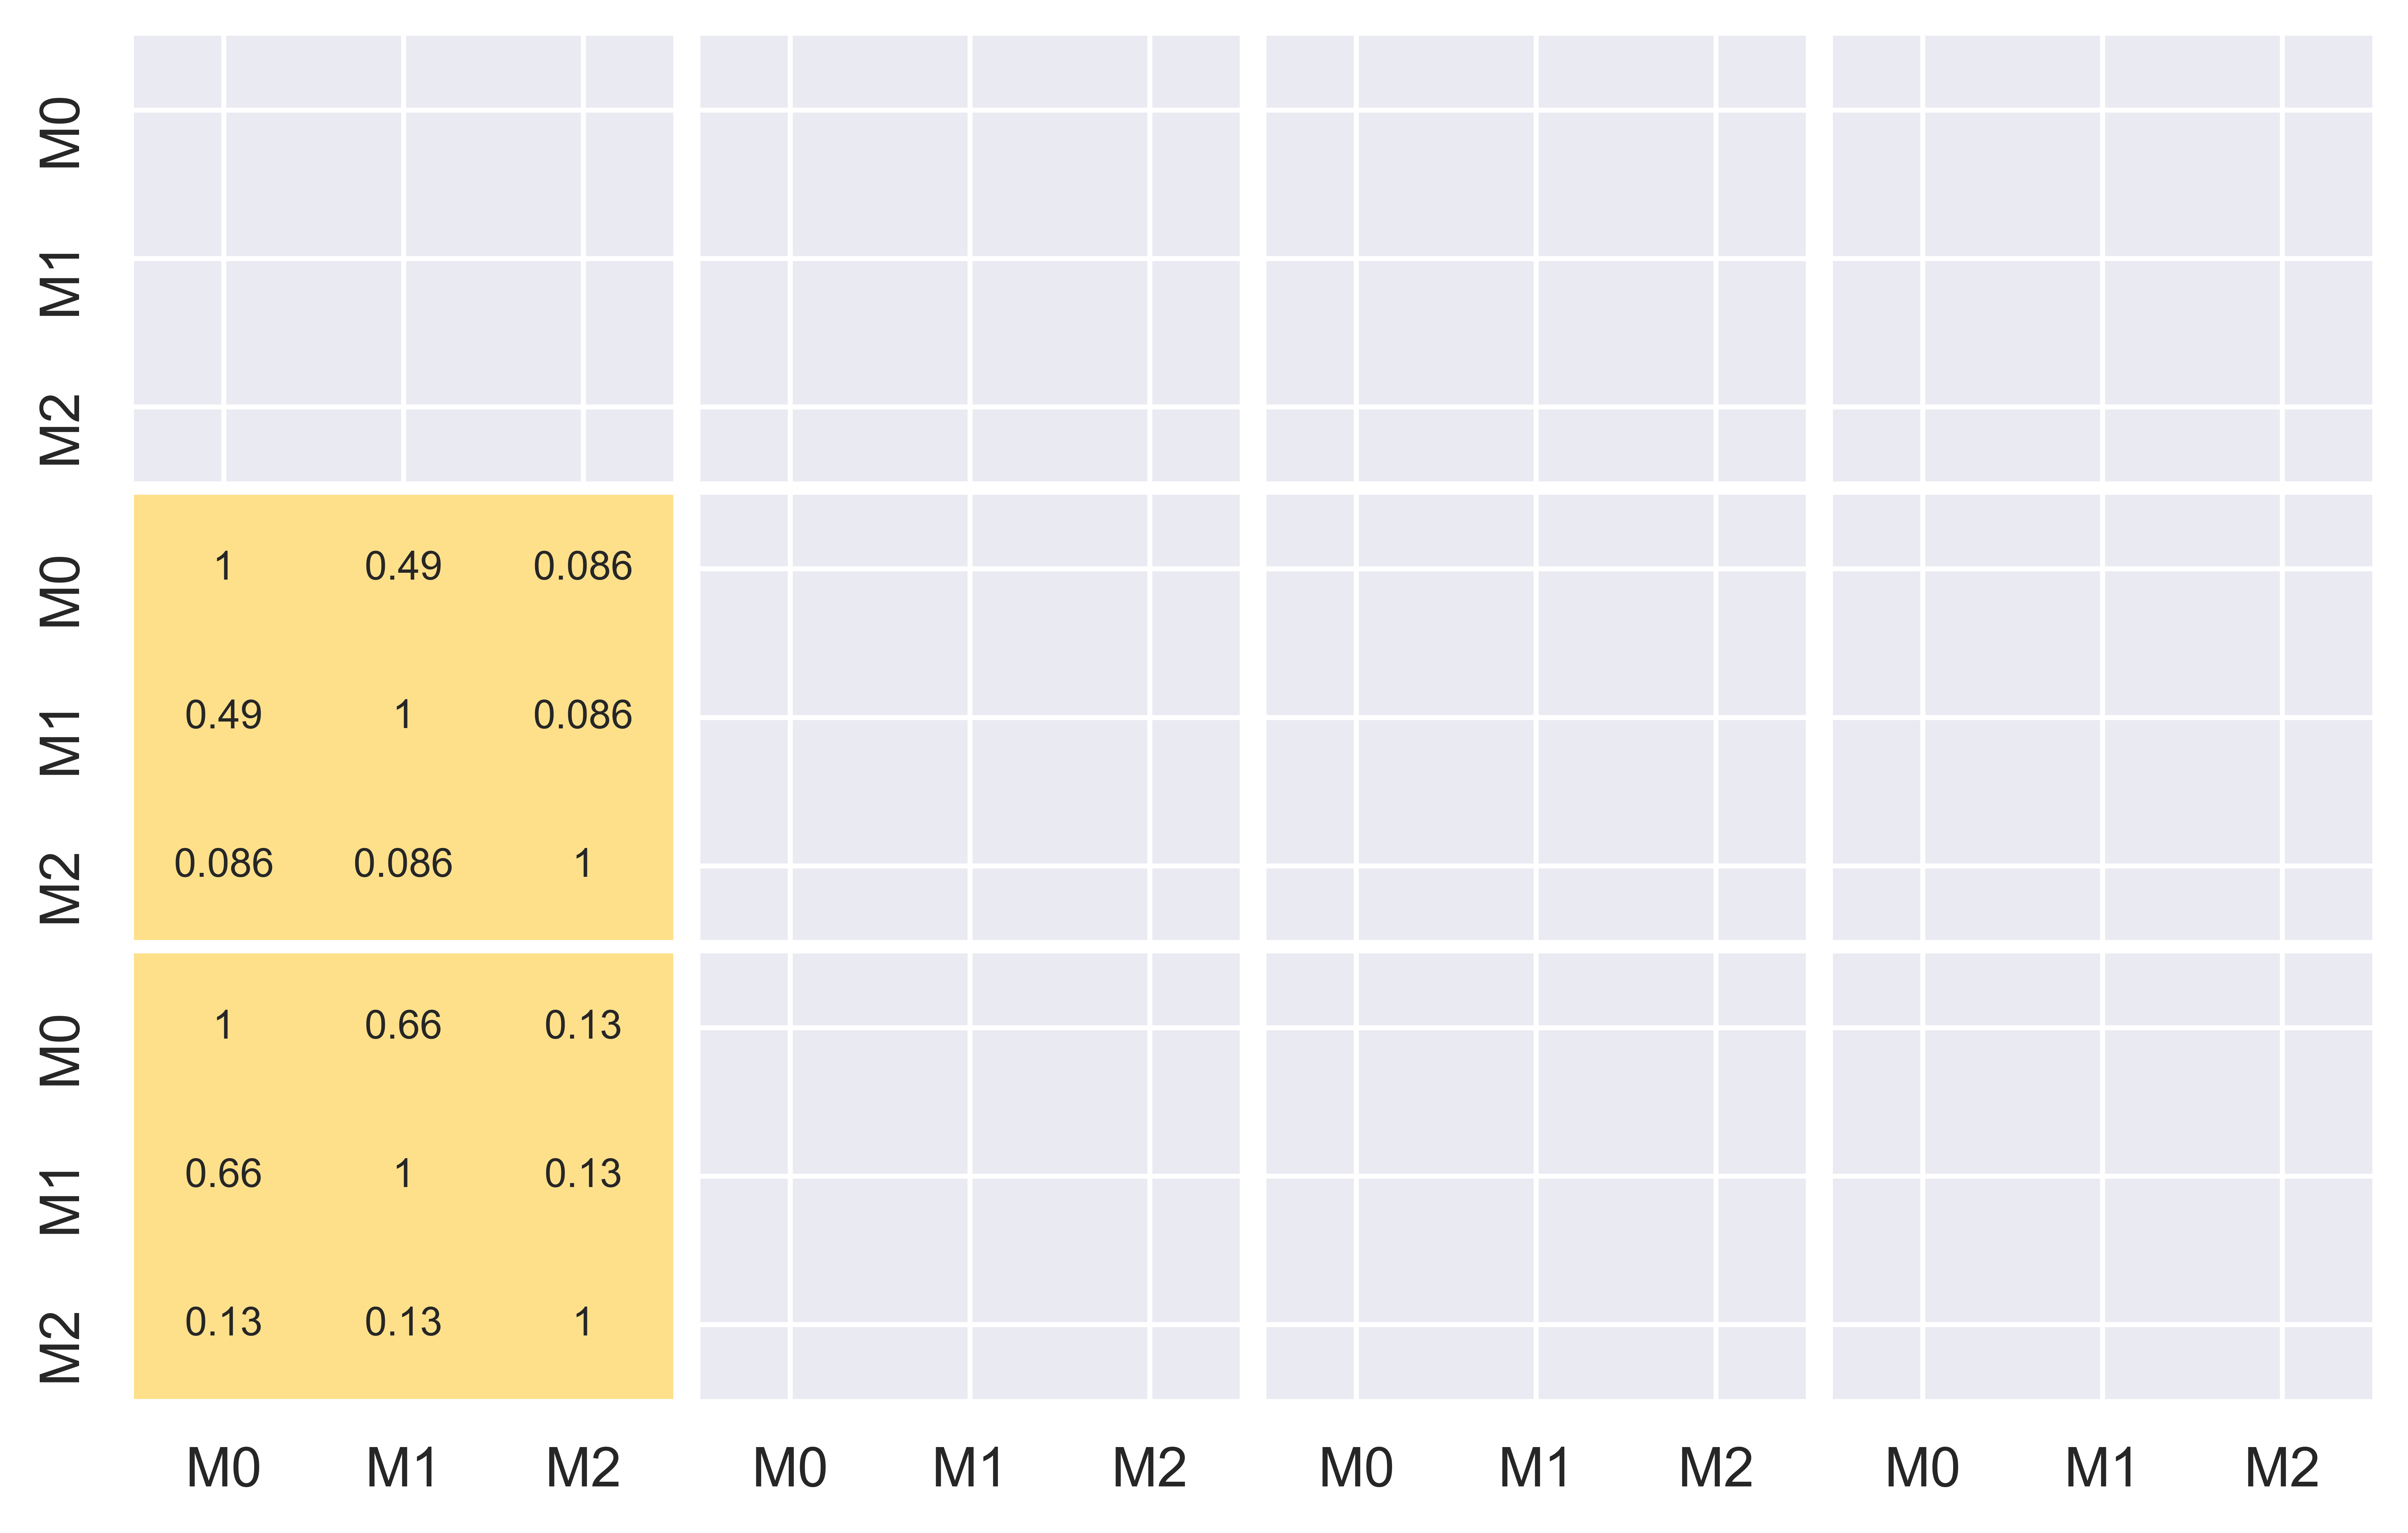

In [24]:
# Looking at signifiance between slices 
import scikit_posthocs as sp
from scipy import stats
alpha= 0.05

hypothesis = np.zeros((3,4,3,3))
hypothesis[:] = np.nan

slices = [2,1,0]
for sl in range(3):
    for dd in range(4):
        group1 = avg_all[0,dd,:,sl]
        group2 = avg_all[1,dd,:,sl]
        group3 = avg_all[2,dd,:, sl]

        normal = 0 if stats.shapiro(group1)[1] <alpha or stats.shapiro(group2)[1] <alpha or stats.shapiro(group1)[1] <alpha else 1

        if normal ==0:
            result = stats.friedmanchisquare(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_wilcoxon([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test
            else:
                hypothesis[sl,dd,:,:] = np.nan

        elif normal ==1:
            result = stats.f_oneway(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_ttest([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test 
            else:
                hypothesis[sl,dd,:,:] = np.nan



from matplotlib.colors import BoundaryNorm, ListedColormap
import seaborn as sns
import numpy as np

my_colors = [sns.color_palette("Spectral",9)[0], sns.color_palette("Spectral",9)[1], sns.color_palette("Spectral",9)[2], 
            sns.color_palette("Spectral",9)[3]]
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.001, 0.01, 0.05,1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

fig, axes = plt.subplots(3, 4, figsize=(8,5),sharex=True,sharey = True,dpi=1000)
count = 2
for sl in range(3):
    for dirs in range(4):
        ax=sns.heatmap(hypothesis[count,dirs,:,:],ax = axes[sl,dirs], annot = True, xticklabels=['M0','M1','M2'],
                    yticklabels=['M0','M1','M2'],norm=my_norm,cmap = my_cmap,cbar = False,annot_kws={"fontsize":8})
        #c_bar = ax.collections[0].colorbar
        #c_bar.set_ticks([(0 + 0.001)/2,(0.001+0.01)/2,(0.01+0.05)/2,(0.05+1)/2])
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  


    count = count -1

plt.subplots_adjust(wspace=0.05, hspace=0.03)


